In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import numpy as np
import warnings

import gymnasium as gym
from gymnasium import spaces
from scipy.optimize import minimize

from cryoenv.mqtt import SoftActorCritic, ReturnTracker, HistoryWriter, CryoWorldModel, generate_sweep, augment_pars, double_tes
%config InlineBackend.figure_formats = ['png']

In [2]:
np.random.seed(8)
torch.cuda.is_available()
# warnings.simplefilter('ignore')
# gym.logger.set_level(40)

False

In [304]:
class ToyCollapseEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    NMBR_STATES = 2
    NMBR_ACTIONS = NMBR_STATES

    def __init__(self, k=-1/3, d=-.5, v=.5, t_max=3, omega=.0):
        super(ToyCollapseEnv, self).__init__()
        self.action_space = spaces.Box(low=- np.ones(self.NMBR_STATES),
                                       high=np.ones(self.NMBR_STATES))
        self.observation_space = spaces.Box(low=- np.ones(self.NMBR_STATES + 1),
                                       high=np.ones(self.NMBR_STATES + 1))
        self.state = np.random.uniform(-1,1,size=self.NMBR_STATES)
        self.state = np.concatenate((self.state, [-1]))
        self.k = k
        self.d = d
        self.v = v
        
        self.t = 0
        self.t_max = t_max
        
        self.omega = omega
        
    def loss(self, x, y):
        loss = (y - self.k * x - self.d - self.t * self.v) ** 2
        return loss
        
    def step(self, action):
        
        info = {}
        
        new_state = np.concatenate((action, [2 * self.t/(self.t_max - 1) - 1]))
        reward = - np.sum(self.loss(*action))
        reward -= self.omega * np.sum((self.state[:2] - action) ** 2)
        terminated = False
        truncated = False
        
        self.state = new_state
        
        # update time
        self.t += 1
        self.t %= self.t_max
        
        return new_state, reward, terminated, truncated, info
    
    def reset(self):
        info = {}
        self.state = np.random.uniform(-1,1,size=self.NMBR_STATES)
        self.t = 0
        self.state = np.concatenate((self.state, [-1]))        
        return self.state, info
        
    def render(self, levels=25, show=True):
        x = np.linspace(-1, 1, 101)
        y = np.linspace(-1, 1, 101)
        xs, ys = np.meshgrid(x, y, sparse=True)

        zs = - self.loss(xs,ys)

        h = plt.contour(x, y, zs, cmap='Greys', levels=levels)
        if show:
            plt.show()

In [305]:
env = ToyCollapseEnv()

In [306]:
state, info = env.reset()

In [307]:
model = SoftActorCritic(env, policy = "GaussianPolicy", critic = "QNetwork", lr=.0003, buffer_size=1300, learning_starts=0,
                        batch_size=16, gamma=.6, gradient_steps=100, grad_clipping=.5, tau=0.005, 
                        device='cuda' if torch.cuda.is_available() else 'cpu',
                        #temperature=0.001,
                        #entropy_tuning=False,
                        target_entropy_reduction=1.,
                       )

In [308]:
tracker = ReturnTracker()
writer = HistoryWriter()

In [309]:
model.learn(episodes = 2, 
            episode_steps = 60, 
            two_pbars=True,
            tracker=tracker,
            writer=writer)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

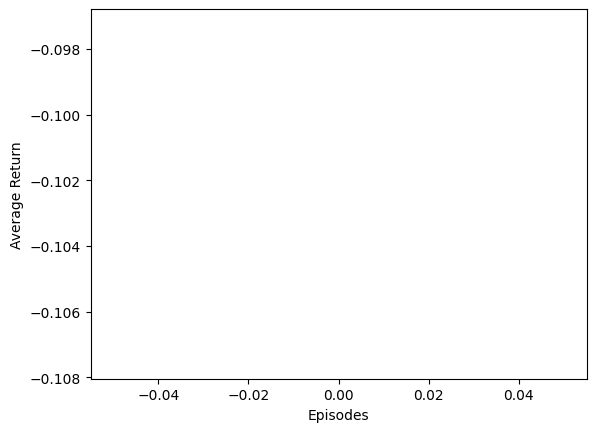

In [310]:
tracker.plot(smooth=1)

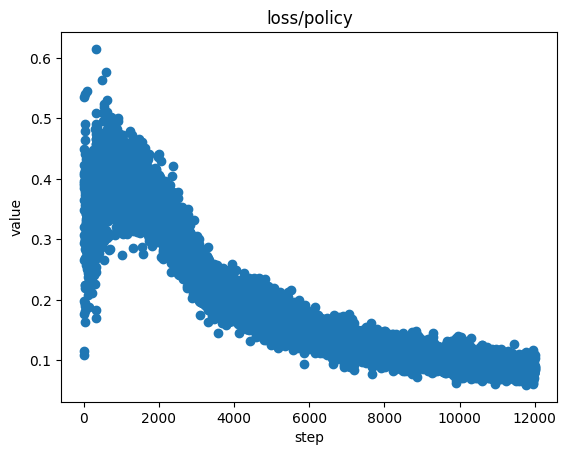

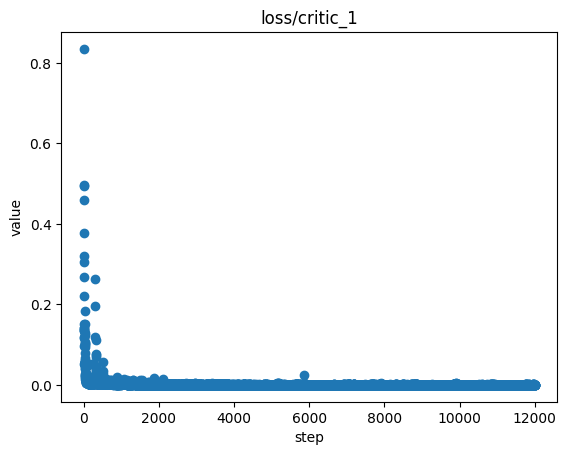

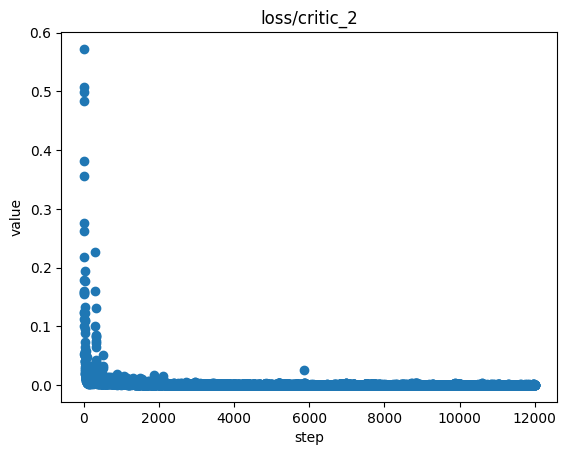

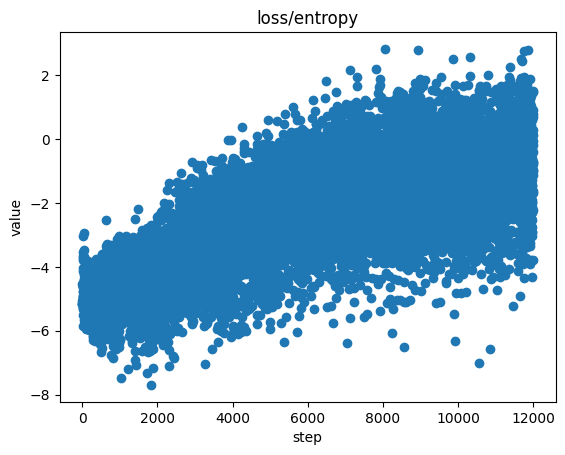

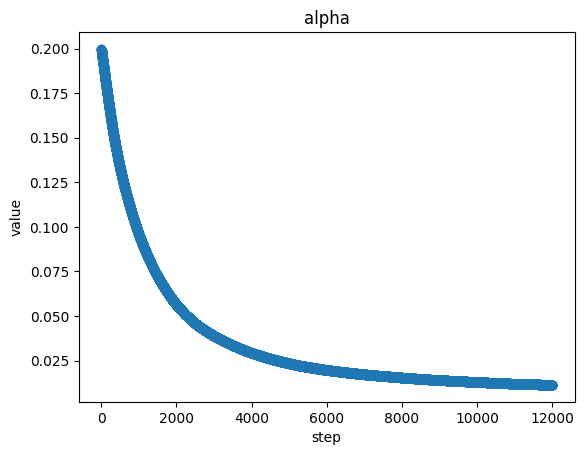

In [311]:
for key in writer.history.keys():
    writer.plot(key)

# Inference

In [312]:
state, info = env.reset()

state_memory = []
action_memory = []
reward_memory = []

for i in range(100):
    
    action, _ = model.predict(state, greedy=True)
    
    new_state, reward, _, _, _, = env.step(action.flatten())
    
    state_memory.append(state)
    action_memory.append(action)
    reward_memory.append(reward)
    
    state = np.copy(new_state)
    
state_memory = np.array(state_memory)
action_memory = np.array(action_memory)
reward_memory = np.array(reward_memory)

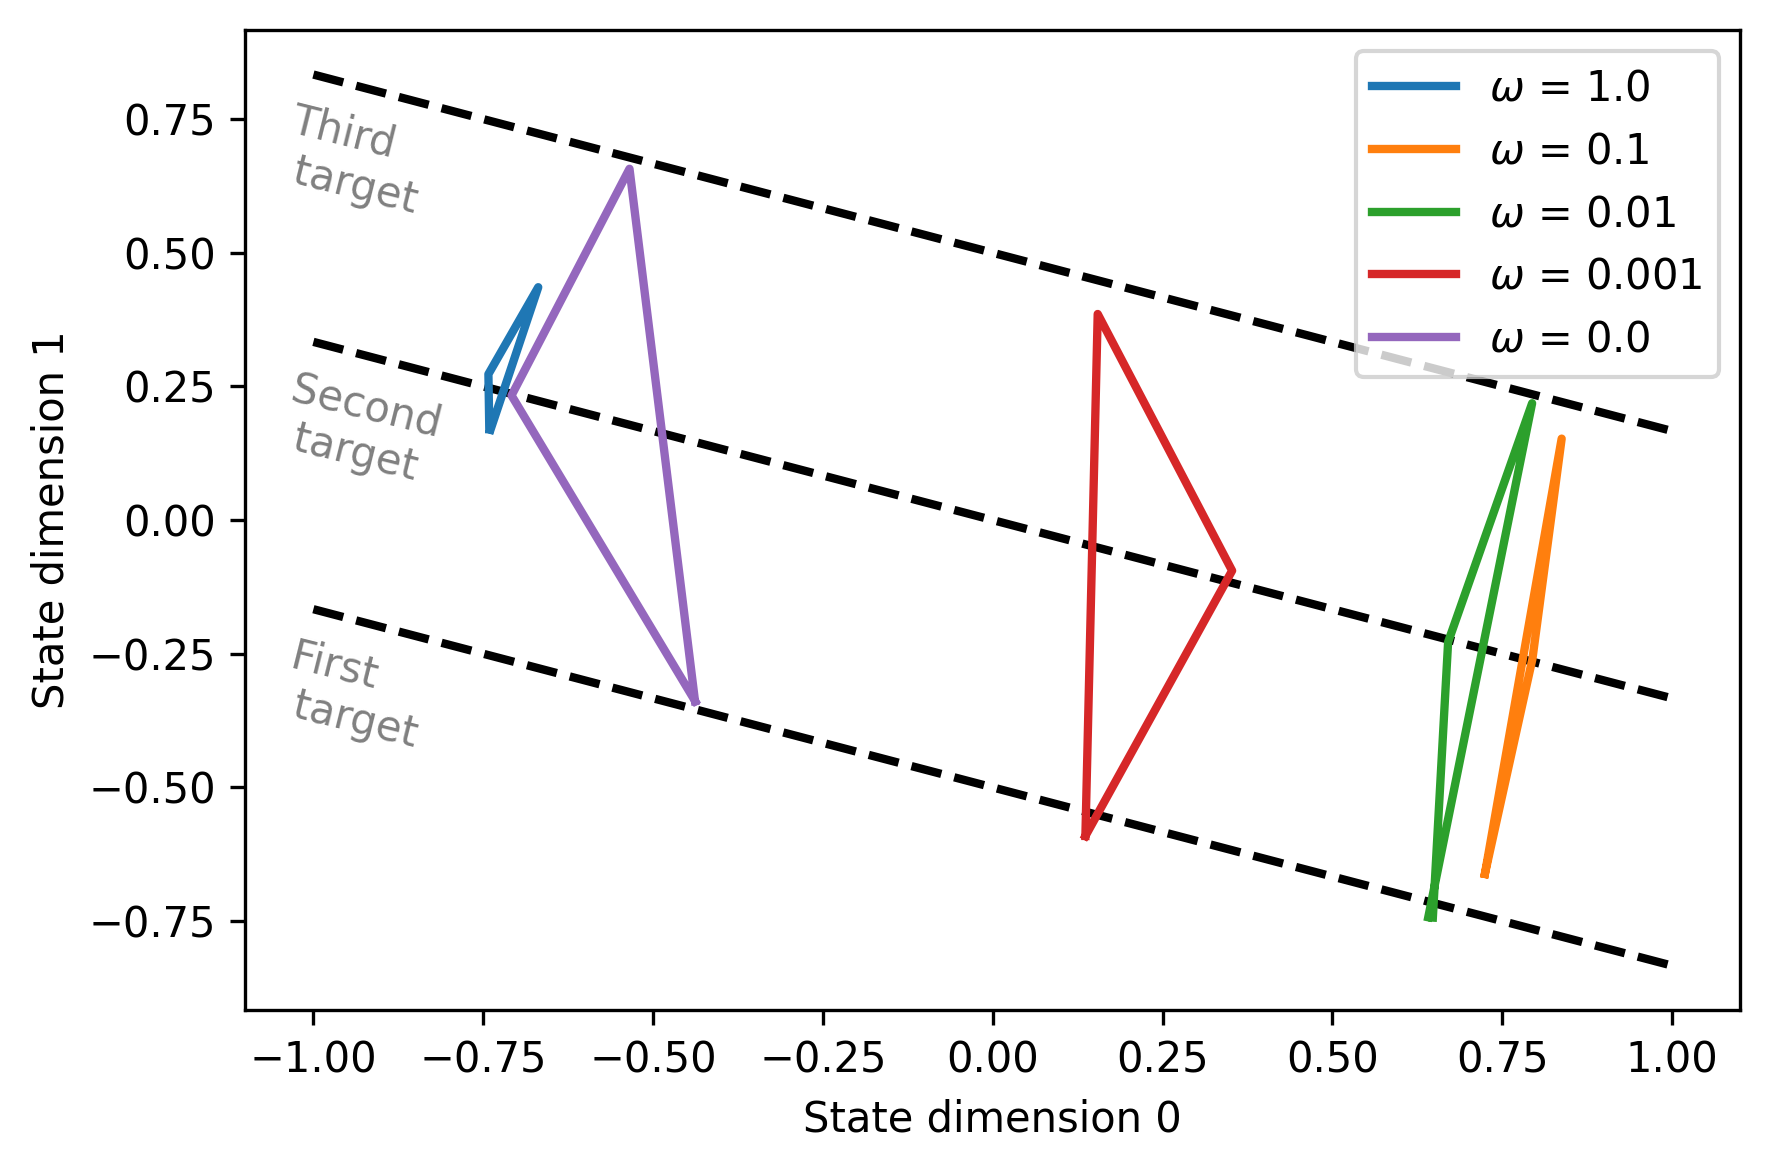

In [351]:
# state, info = env.reset()
# env.render(show=False)

plt.figure(figsize=(6,4), dpi=300)

plt.plot([-1, 0, 1], [env.k * -1 + env.d + env.v*0, env.k * 0 + env.d + env.v*0, env.k * 1 + env.d + env.v*0], 
         color='black', linewidth=2, linestyle='dashed')
plt.plot([-1, 0, 1], [env.k * -1 + env.d + env.v*1, env.k * 0 + env.d + env.v*1, env.k * 1 + env.d + env.v*1], 
         color='black', linewidth=2, linestyle='dashed')
plt.plot([-1, 0, 1], [env.k * -1 + env.d + env.v*2, env.k * 0 + env.d + env.v*2, env.k * 1 + env.d + env.v*2], 
         color='black', linewidth=2, linestyle='dashed')

for i,omega in enumerate(['1_0', '0_1', '0_01', '0_001', '0_0', ]):  # '1_0', '0_1', '0_01', '0_001', '0_0001', '0_00001', '0_000001', '0_0', 
    x = np.load('saved_pars/collapse_state_memory_omega_{}.npy'.format(omega))
    plt.plot(x[7:7+4,0], x[7:7+4,1], color='C'+str(i), label='$\omega$ = {}'.format(omega).replace('_', '.'), 
             linewidth=2.)

plt.text(x=-1.05, y= -0.35, s='First \n target', rotation = -14, rotation_mode = 'anchor', color='grey')
plt.text(x=-1.05, y= 0.15, s='Second \n target', rotation = -14, rotation_mode = 'anchor', color='grey')
plt.text(x=-1.05, y= 0.65, s='Third \n target', rotation = -14, rotation_mode = 'anchor', color='grey')

plt.legend()
plt.xlabel('State dimension 0')
plt.ylabel('State dimension 1')
plt.tight_layout()
plt.savefig('plots_paper/collapsed_objective.png')
plt.show()

In [317]:
# np.save('saved_pars/collapse_state_memory_omega_0_0.npy', state_memory)